Imports and data.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)
reactions = dg.collection.ReactionCollection([dg.reaction.LazyReaction(r.template, id=r.id) for r in reactions])

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

load data


Define library designer.

In [2]:
from dgym.envs.library_designer import LibraryDesigner

library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Reconstruct a molecule as a generator.

### Construct logic of new Library Designer

In [3]:
import inspect
import random

def retrosynthesize(molecule, protect=False):
    
    # Base cases
    if inspect.isgenerator(molecule):
        return molecule
    
    elif not molecule.reactants:
        return molecule
    
    # Recursive case: Retrosynthesize each reactant
    retrosynthesized_reactants = [retrosynthesize(reactant) for reactant in molecule.reactants]
        
    # Use the reaction to reconstruct the original molecule from its reactants
    if molecule.reaction is None:
        molecule.reaction = library_designer.match_reactions(molecule)[0]

    output = molecule.reaction.run(retrosynthesized_reactants, protect=protect)
    
    return output

In [14]:
from dgym.envs.library_designer import AnalogGenerator

generator = AnalogGenerator(building_blocks, fingerprints)

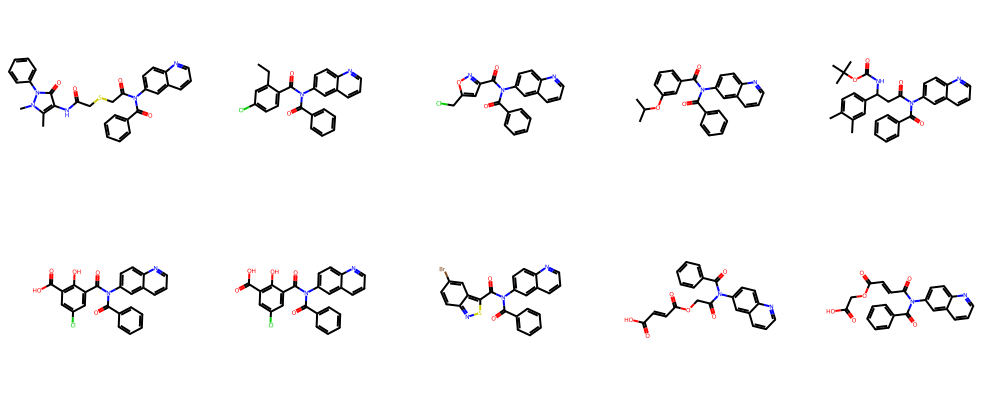

In [66]:
import itertools
from dgym.molecule import Molecule

size = 10
molecule = deck[31]
mode = 'expand'

if mode == 'analog':
    target_reactions = library_designer.match_reactions(molecule)

elif mode == 'expand':
    target_reactions = library_designer.reactions

# Perform reactions
products = []
if mode == 'analog':
    
    for reaction in library_designer.match_reactions(molecule):
        with molecule.set_reaction(reaction):

            # Replace reactants with analog generators
            generator_ = generator(molecule.reactants[0], temperature=0.0)
            with molecule.set_reactants(generator_, 0):

                # Lazy load molecule analogs
                analogs = retrosynthesize(molecule, protect=False)

                # Run reaction
                for analog in analogs:
                    if len(products) < size:
                        products.append(analog)
                    else:
                        break

elif mode == 'expand':

    for reaction in library_designer.reactions:
        with molecule.set_reactants([molecule, generator()]):

            if len(reaction.reactants) == len(molecule.reactants):
                
                analogs = reaction.run(molecule.reactants, protect=False)
                for analog in analogs:
                    if len(products) < size:
                        products.append(analog)
                    else:
                        break

from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([p.mol for p in products], molsPerRow=5)